In [1]:
# 1.  libraries preparation and file handling/ arrays/ image processing.
import os
import numpy as np
import pickle
from tqdm import tqdm
from PIL import Image
import torch
from torch import nn
from torchvision import models, transforms

######TensorFlow and Keras modules for image preprocessing and model building

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

from collections import defaultdict                                            # For organizing captions efficiently


# Define paths to captions and image directory, and precomputed VGG16 
captions_path = "/lab2/captions.txt"
image_dir = "/lab2/Images"
features_path = "/lab2/vgg16_features.pkl"

# GPU/CPU Check 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
#################################################################################################################################################################################

# 2. Load and process captions ++ Read the raw captions file line-by-line
with open(captions_path, "r") as f:
    lines = f.readlines()

print("Total captions:", len(lines))

# Store captions x image_ID : in a dictionary 
captions_dict = defaultdict(list)
for line in lines:
    line = line.strip()
    if not line or ',' not in line:
        continue  # Skip empty or malformed lines
    img_id, caption = line.split(',', 1)
    captions_dict[img_id].append(caption.lower())  # Store caption in lowercase

# Wrap each caption with special <start> and <end> tokens
all_captions = ['<start> ' + cap.strip() + ' <end>' 
                for caps in captions_dict.values() for cap in caps]

# 3. Tokenization: Initialize tokenizer with a vocabulary limit 
tokenizer = Tokenizer(num_words=10000, oov_token="<unk>")
tokenizer.fit_on_texts(all_captions)  # Fit tokenizer on all captions
sequences = tokenizer.texts_to_sequences(all_captions)  # to Convert text to integer sequences
vocab_size = len(tokenizer.word_index) + 1  # Total vocab size (+1 for padding token)
max_length = max(len(seq) for seq in sequences)  # Max length of any caption-----> to be used to limit the length later

# Pad all sequences to the same max length for input to LSTM >> fill with Zeros, which we will exclude later
padded_captions = pad_sequences(sequences, maxlen=max_length, padding='post')
print("Vocabulary size:", vocab_size)
print("Max caption length:", max_length)

#  4. VGG16 Feature Extraction: Import layer to do pooling on image features
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load VGG16 model without its top classification layer >> No lables, Only features
base_model = VGG16(weights="imagenet", include_top=False)
#------------------------------------------------------------ Replace top with GlobalAveragePooling2D to get compact feature vectors
model = Model(inputs=base_model.input,
              outputs=GlobalAveragePooling2D()(base_model.output))

# Function to load, resize, and preprocess a single image
def load_and_preprocess(img_path):
    img = Image.open(img_path).convert("RGB").resize((224, 224))  # Resize and convert to RGB
    arr = img_to_array(img)  # Convert to NumPy array
    arr = np.expand_dims(arr, axis=0)  # Add batch dimension
    arr = preprocess_input(arr.astype("float32"))  # Apply VGG-specific preprocessing
    return arr

# Extract features  and store them in a dictionary
image_features = {}
for fname in tqdm(os.listdir(image_dir)):
    if not fname.lower().endswith(".jpg"):
        continue  # Skip non-JPG files
    fpath = os.path.join(image_dir, fname)
    img = load_and_preprocess(fpath)
    feats = model.predict(img, verbose=0)  # Predict features using VGG16
    image_features[fname] = feats.squeeze()  # Remove unnecessary dimensions

# Save the extracted image features to a pickle file
with open(features_path, "wb") as f:
    pickle.dump(image_features, f)

print(f"Extracted and saved features for {len(image_features)} images")

# 5. Define Data Preparation Function  to train sequences from captions and image features
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = [], [], []
    for key, desc_list in descriptions.items():
        if key not in photos:
            continue  # Skip if image feature is not found
        for desc in desc_list:
            desc = '<start> ' + desc.strip() + ' <end>'  # Add tokens
            seq = tokenizer.texts_to_sequences([desc])[0]  # Convert to sequence
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]  # Create input-output pair
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]  # Pad input sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]  # One-hot encode output
                X1.append(photos[key])  # Image feature
                X2.append(in_seq)       # Padded text input
                y.append(out_seq)       # One-hot output word
    return np.array(X1), np.array(X2), np.array(y)

# 6. Load Features and Prepare Training Data ----->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Load pre-extracted image features
with open(features_path, 'rb') as f:
    features = pickle.load(f)

# Generate training data: image inputs, text inputs, and output labels
X1_train, X2_train, y_train = create_sequences(tokenizer, max_length, captions_dict, features, vocab_size)

# Print shapes of training data arrays
print(f"Image features input shape: {X1_train.shape}")
print(f"Caption input shape: {X2_train.shape}")
print(f"Target output shape: {y_train.shape}")

# 7. Define Model + Define image --->> input branch

image_input = Input(shape=(512,))  # VGG16 feature vector
image_dropout = Dropout(0.5)(image_input)
image_dense = Dense(256, activation='relu')(image_dropout)

# Define caption input branch
caption_input = Input(shape=(max_length,))  # Sequence input
caption_embedding = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(caption_input)
caption_lstm = LSTM(256)(caption_embedding)  # LSTM to process embedded sequence

# Combine image and caption features
decoder = add([image_dense, caption_lstm])  # Merge features
decoder = Dense(256, activation='relu')(decoder)  # Hidden layer
output = Dense(vocab_size, activation='softmax')(decoder)  # Final output layer (word probabilities)

# Compile the model
model = Model(inputs=[image_input, caption_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Print model summary
model.summary()


2025-05-13 12:59:21.915966: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 12:59:21.961213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using device: cuda
Total captions: 40456
Vocabulary size: 8496
Max caption length: 39


2025-05-13 12:59:24.976989: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
100%|██████████| 330/330 [00:42<00:00,  7.70it/s]


Extracted and saved features for 329 images
Image features input shape: (19815, 512)
Caption input shape: (19815, 39)
Target output shape: (19815, 8496)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 39)]                 0         []                            
                                                                                                  
 dropout (Dropout)           (None, 512)                  0         ['input_2[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 39

Epoch 1/20
310/310 [==============================] - ETA: 0s - loss: 5.4265
Epoch 1: loss improved from inf to 5.42654, saving model to best_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


310/310 [==============================] - 44s 130ms/step - loss: 5.4265
Epoch 2/20
310/310 [==============================] - ETA: 0s - loss: 4.4548
Epoch 2: loss improved from 5.42654 to 4.45481, saving model to best_model.h5
310/310 [==============================] - 38s 123ms/step - loss: 4.4548
Epoch 3/20
310/310 [==============================] - ETA: 0s - loss: 3.9403
Epoch 3: loss improved from 4.45481 to 3.94033, saving model to best_model.h5
310/310 [==============================] - 39s 125ms/step - loss: 3.9403
Epoch 4/20
310/310 [==============================] - ETA: 0s - loss: 3.5305
Epoch 4: loss improved from 3.94033 to 3.53055, saving model to best_model.h5
310/310 [==============================] - 39s 124ms/step - loss: 3.5305
Epoch 5/20
310/310 [==============================] - ETA: 0s - loss: 3.1926
Epoch 5: loss improved from 3.53055 to 3.19262, saving model to best_model.h5
310/310 [==============================] - 39s 125ms/step - loss: 3.1926
Epoch 6/20
310/

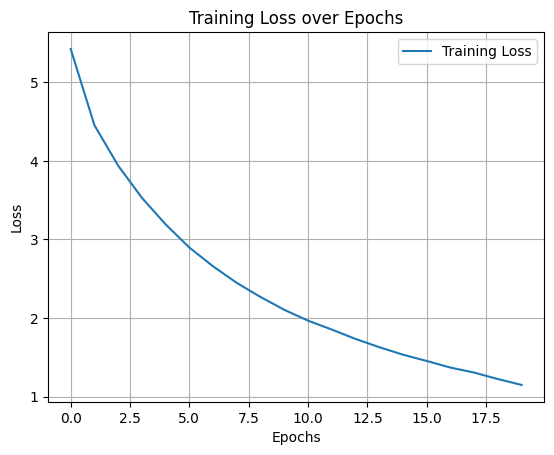

In [2]:
# Import necessary tools
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  #................................. For saving models and stopping training early
import matplotlib.pyplot as plt  


#to save the model with the lowest training loss
checkpoint = ModelCheckpoint(
    'best_model.h5',               # Path to save the model file
    monitor='loss',                # to monitor  training loss
    save_best_only=True,           # Save only when the loss improves
    verbose=1                      # Print message when model is saved
)

#to stop training when loss stops improving
early_stop = EarlyStopping(
    monitor='loss',                # Monitor the training loss
    patience=3,                    # Wait for 3 epochs without improvement
    restore_best_weights=True,     # Restore weights from the best epoch
    verbose=1                      # Print message when training stops
)


# Compile loss and optimizer
model.compile(
    loss='categorical_crossentropy',  # Loss function ------->> multi-class classification
    optimizer='adam'                  # learning rate vs. eff
)

#  training data
history = model.fit(
    [X1_train, X2_train],       # Inputs: image features (X1), and text sequences (X2)
    y_train,                    # Target outputs: next word in caption (one-hot encoded)
    epochs=20,                  
    batch_size=64,              
    callbacks=[checkpoint, early_stop]  # Use callbacks for saving and early stopping
)


# Plot the training loss over epochs
plt.plot(history.history['loss'], label='Training Loss')  
plt.title('Training Loss over Epochs')                    
plt.xlabel('Epochs')                                      
plt.ylabel('Loss')                                        
plt.legend()                                              
plt.grid(True)                                            
plt.show()                                                


In [3]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np


model = load_model("best_model.h5")                                # Load the trained image captioning model from the saved file
base_model = VGG16(weights="imagenet", include_top=False)          # Load the pre-trained VGG16 model for feature extraction + Only keep convolutional base (exclude classification layers)


vgg_model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output)) # Add Global Average Pooling to reduce feature maps to a vector of shape (512,)


def extract_features(img_path, model):                                                          #Feature Extraction Function  to load an image, preprocess it, and extract features using VGG16

    img = Image.open(img_path).convert("RGB").resize((224, 224))                     # Load and resize image
    arr = img_to_array(img)                                                          # Convert image to NumPy array
    arr = np.expand_dims(arr, axis=0)                                                # Add batch dimension
    arr = preprocess_input(arr.astype("float32"))                                    # Preprocess as expected by VGG16
    features = model.predict(arr, verbose=0)                                         # Extract feature vector (shape: (1, 512))
    return features


# Caption Generation Function : to Generate a caption for a given photo feature using the trained model and tokenizer

def generate_caption(model, tokenizer, photo, max_length):
    in_text = '<start>'          # Start token
    for _ in range(max_length):  # Limit caption to max_length
        sequence = tokenizer.texts_to_sequences([in_text])[0]     # Convert current caption to sequence
        sequence = pad_sequences([sequence], maxlen=max_length)   # Pad sequence
        yhat = model.predict([photo, sequence], verbose=0)       # Predict next word
        yhat = np.argmax(yhat)                                    # Get index of most probable word
        word = tokenizer.index_word.get(yhat)                     # Convert index to word

        if word is None:
            break  # Stop if word not found in tokenizer

        in_text += ' ' + word  # Append predicted word to the caption
        if 'end' in word:
            break  # Stop if end token is predicted

    # Clean up generated text by removing <start> and <end> tokens
    return in_text.replace('<start>', '').replace('<end>', '').strip()



Generated Caption: a man and woman sitting on a rock surface end


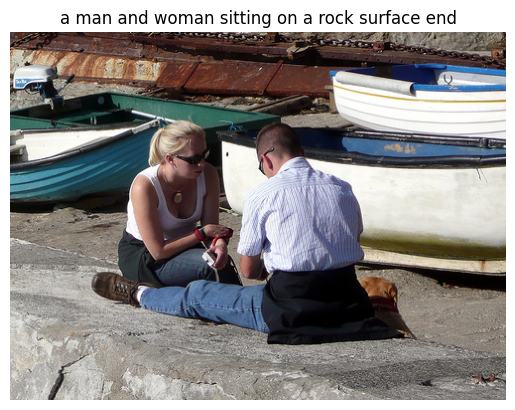

In [4]:
#  Test 1
test_image_path = "/lab2/Images/1348957576_c4a78eb974.jpg"

# Extract VGG16 features
photo_features = extract_features(test_image_path, vgg_model)

# Generate caption using the trained model
caption = generate_caption(model, tokenizer, photo_features, max_length)
print("Generated Caption:", caption)

# Display the image and generated caption using matplotlib
img = Image.open(test_image_path)
plt.imshow(img)           
plt.axis('off')          
plt.title(caption)        
plt.show()                

Generated Caption: a man in a hat is displaying pictures next to a skier and a man looks on end


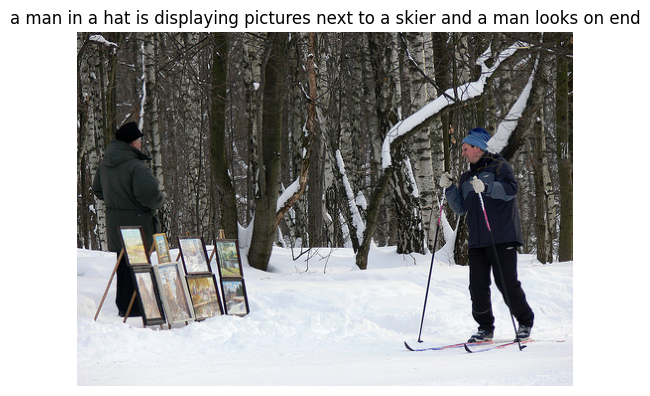

In [5]:
#  Test 2
test_image_path = "/lab2/Images/101669240_b2d3e7f17b.jpg"

# Extract VGG16 features
photo_features = extract_features(test_image_path, vgg_model)

# Generate caption using the trained model
caption = generate_caption(model, tokenizer, photo_features, max_length)
print("Generated Caption:", caption)

# Display the image and generated caption using matplotlib
img = Image.open(test_image_path)
plt.imshow(img)           
plt.axis('off')          
plt.title(caption)        
plt.show()                

Generated Caption: a black and white dog is running through the dirt end


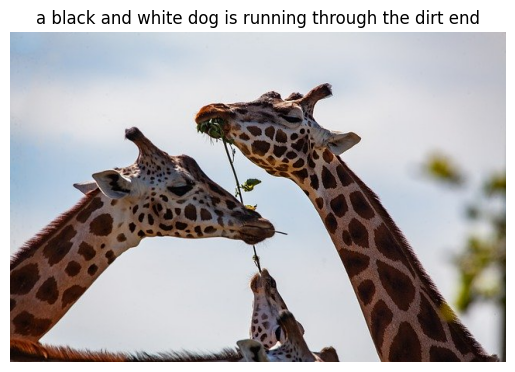

In [6]:
#  Test 2
test_image_path = "/lab2/myrandomimages/mygiraf.jpg"

# Extract VGG16 features
photo_features = extract_features(test_image_path, vgg_model)

# Generate caption using the trained model
caption = generate_caption(model, tokenizer, photo_features, max_length)
print("Generated Caption:", caption)

# Display the image and generated caption using matplotlib
img = Image.open(test_image_path)
plt.imshow(img)           
plt.axis('off')          
plt.title(caption)        
plt.show()   

Generated Caption: a television with a red shirt is sitting on the fountain of a wooden bench end


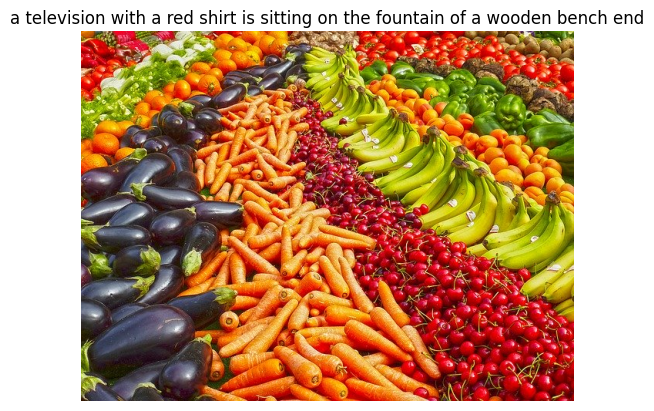

In [7]:
#  Test 2
test_image_path = "/lab2/myrandomimages/myfruits.jpg"

# Extract VGG16 features
photo_features = extract_features(test_image_path, vgg_model)

# Generate caption using the trained model
caption = generate_caption(model, tokenizer, photo_features, max_length)
print("Generated Caption:", caption)

# Display the image and generated caption using matplotlib
img = Image.open(test_image_path)
plt.imshow(img)           
plt.axis('off')          
plt.title(caption)        
plt.show()   

Generated Caption: a brown dog is running on the snow end


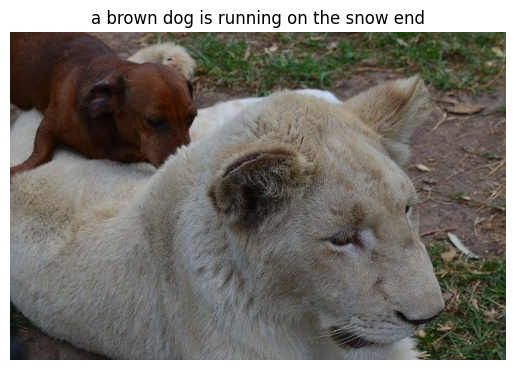

In [8]:
#  Test 2
test_image_path = "/lab2/myrandomimages/lion-with-dog.jpg"

# Extract VGG16 features
photo_features = extract_features(test_image_path, vgg_model)

# Generate caption using the trained model
caption = generate_caption(model, tokenizer, photo_features, max_length)
print("Generated Caption:", caption)

# Display the image and generated caption using matplotlib
img = Image.open(test_image_path)
plt.imshow(img)           
plt.axis('off')          
plt.title(caption)        
plt.show()   